In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tarfile
import math

from tensorflow import keras
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
from keras.callbacks import ReduceLROnPlateau

In [3]:
from keras.layers import AlphaDropout

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
from numpy.random import seed
seed(15)

from tensorflow.random import set_seed
set_seed(15)

In [6]:
brooklyn_csv = '/content/drive/MyDrive/Boro_DFs/bklyn_df.csv'

In [7]:
brooklyn_df = pd.DataFrame(pd.read_csv(brooklyn_csv))

In [8]:
brooklyn_df.head()

,Borough,Area,Address,Num_Beds,Num_Baths,Sq-Ft,Rent,Long,Lat,ZipCode,Precinct,CrimeTotalPastYear,Train_Line,Dist_To_Line,Dist_To_Station,Dist_To_Entrance
0,brooklyn,Prospect Lefferts Gardens,620 Parkside Avenue,3.0,1.0,1067.73,3100.0,-73.952639,40.656024,11226.0,71.0,954.0,2,0.002519,0.002638,0.002298
1,brooklyn,Williamsburg,1 N 4th Place,1.0,1.0,600.00,4597.0,-74.000048,40.678412,11231.0,76.0,406.0,F,0.003447,0.005430,0.004440
2,brooklyn,Bensonhurst,1651 84th Street,2.0,1.0,600.00,1650.0,-74.004634,40.610703,11214.0,62.0,1179.0,D,0.003225,0.004249,0.004048
3,brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,181 Front Street,2.0,2.0,1290.54,6496.0,-73.985988,40.702526,11201.0,84.0,1063.0,F,0.001683,0.002925,0.001326
4,brooklyn,East Flatbush,3420 Clarendon Road,1.0,1.0,624.88,1600.0,-73.944233,40.643375,11203.0,67.0,1832.0,5,0.004833,0.004935,0.004754


In [9]:
y = brooklyn_df[['Rent']]

In [10]:
X = brooklyn_df.drop(['Borough', 'Rent'], axis=1)
X.head()

,Area,Address,Num_Beds,Num_Baths,Sq-Ft,Long,Lat,ZipCode,Precinct,CrimeTotalPastYear,Train_Line,Dist_To_Line,Dist_To_Station,Dist_To_Entrance
0,Prospect Lefferts Gardens,620 Parkside Avenue,3.0,1.0,1067.73,-73.952639,40.656024,11226.0,71.0,954.0,2,0.002519,0.002638,0.002298
1,Williamsburg,1 N 4th Place,1.0,1.0,600.00,-74.000048,40.678412,11231.0,76.0,406.0,F,0.003447,0.005430,0.004440
2,Bensonhurst,1651 84th Street,2.0,1.0,600.00,-74.004634,40.610703,11214.0,62.0,1179.0,D,0.003225,0.004249,0.004048
3,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,181 Front Street,2.0,2.0,1290.54,-73.985988,40.702526,11201.0,84.0,1063.0,F,0.001683,0.002925,0.001326
4,East Flatbush,3420 Clarendon Road,1.0,1.0,624.88,-73.944233,40.643375,11203.0,67.0,1832.0,5,0.004833,0.004935,0.004754


In [11]:
X = pd.get_dummies(X, columns=['Area', 'Address', 'ZipCode', 'Precinct', 'Train_Line'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [13]:
numeric_cols = ['Num_Beds', 'Num_Baths', 'Sq-Ft', 'Long', 'Lat', 'CrimeTotalPastYear', 'Dist_To_Line', 'Dist_To_Station', 'Dist_To_Entrance']

In [14]:
X_train_num = X_train[numeric_cols]

In [15]:
X_test_num = X_test[numeric_cols]

In [16]:
print(X_train_num.shape)
print(X_test_num.shape)

(4150, 9)
(1038, 9)


In [17]:
scaler = MinMaxScaler()

In [18]:
X_train_num = scaler.fit_transform(X_train_num)

In [19]:
X_train_num.shape

(4150, 9)

In [20]:
X_test_num = scaler.transform(X_test_num)

In [21]:
X_test_num.shape

(1038, 9)

In [22]:
X_train_onehots = X_train.drop(numeric_cols, axis=1)
X_test_onehots = X_test.drop(numeric_cols, axis=1)

In [23]:
X_train_onehots.shape

(4150, 3052)

In [24]:
X_test_onehots.shape

(1038, 3052)

In [25]:
X_train = np.concatenate((X_train_num, X_train_onehots), axis=1)

In [26]:
X_test = np.concatenate((X_test_num, X_test_onehots), axis=1)

In [27]:
# create validation set
num_val_insts = math.floor(X_train.shape[0]*(.10))

X_val = X_train[:num_val_insts]
y_val = y_train[:num_val_insts]

X_train = X_train[num_val_insts:]
y_train = y_train[num_val_insts:]

In [28]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3735, 3061), y_train shape: (3735, 1)
X_val shape: (415, 3061), y_val shape: (415, 1)
X_test shape: (1038, 3061), y_test shape: (1038, 1)


In [29]:
from keras.initializers import lecun_normal

In [30]:
initialiser = lecun_normal(seed=31)

In [72]:
# model 1

# model = models.Sequential()
# model.add(layers.Dense(100, activation='selu', input_shape=(X_train.shape[1],), kernel_initializer=initialiser))
# model.add(layers.Dense(100, activation='selu', kernel_initializer=initialiser))
# model.add(layers.Dense(100, activation='selu', kernel_initializer=initialiser))
# model.add(layers.Dense(100, activation='selu', kernel_initializer=initialiser))
# model.add(layers.Dense(100, activation='selu', kernel_initializer=initialiser))
# model.add(layers.Dense(100, activation='selu', kernel_initializer=initialiser))
# model.add(layers.Dense(1))


# model 2

model = models.Sequential()
model.add(layers.Dense(512, activation='selu', input_shape=(X_train.shape[1],), kernel_initializer=initialiser))
model.add(layers.Dense(512, activation='selu', kernel_initializer=initialiser))
model.add(layers.Dense(512, activation='selu', kernel_initializer=initialiser))
model.add(layers.Dense(512, activation='selu', kernel_initializer=initialiser))
model.add(layers.Dense(512, activation='selu', kernel_initializer=initialiser))
model.add(layers.Dense(512, activation='selu', kernel_initializer=initialiser))
model.add(layers.Dense(512, activation='selu', kernel_initializer=initialiser))

model.add(layers.Dense(256, activation='selu', kernel_initializer=initialiser))
model.add(layers.Dense(256, activation='selu', kernel_initializer=initialiser))

model.add(layers.Dense(128, activation='selu', kernel_initializer=initialiser))
model.add(layers.Dense(128, activation='selu', kernel_initializer=initialiser))

model.add(layers.Dense(64, activation='selu', kernel_initializer=initialiser))
model.add(layers.Dense(64, activation='selu', kernel_initializer=initialiser))


model.add(layers.Dense(1))

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 512)               1567744   
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dense_39 (Dense)            (None, 512)               262656    
                                                                 
 dense_40 (Dense)            (None, 512)               262656    
                                                                 
 dense_41 (Dense)            (None, 512)              

In [74]:
model.compile(loss="huber_loss", optimizer=keras.optimizers.Adam(learning_rate=.001), metrics=["mae"])

In [75]:
early_stop = EarlyStopping(monitor='val_mae', mode='min', 
                           verbose=1, patience=50, min_delta=.5, 
                           restore_best_weights=True)

In [76]:
#reduce on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_mae',
    patience=25,
    factor=.1,
    mode='min',
    min_delta=.5,
    verbose=1,
    min_lr=.0001
)

In [77]:
history = model.fit(X_train, y_train, epochs=500,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr])

Epoch 1/500
117/117 [==============================] - 1s 5ms/step - loss: 1048.1287 - mae: 1048.6285 - val_loss: 860.8810 - val_mae: 861.3810 - lr: 0.0010
Epoch 2/500
117/117 [==============================] - 0s 4ms/step - loss: 596.0584 - mae: 596.5580 - val_loss: 640.8477 - val_mae: 641.3477 - lr: 0.0010
Epoch 3/500
117/117 [==============================] - 0s 4ms/step - loss: 490.6024 - mae: 491.1022 - val_loss: 567.0977 - val_mae: 567.5966 - lr: 0.0010
Epoch 4/500
117/117 [==============================] - 0s 4ms/step - loss: 452.4113 - mae: 452.9108 - val_loss: 583.4516 - val_mae: 583.9516 - lr: 0.0010
Epoch 5/500
117/117 [==============================] - 0s 4ms/step - loss: 444.4106 - mae: 444.9100 - val_loss: 597.5906 - val_mae: 598.0906 - lr: 0.0010
Epoch 6/500
117/117 [==============================] - 0s 4ms/step - loss: 411.9563 - mae: 412.4557 - val_loss: 495.0732 - val_mae: 495.5731 - lr: 0.0010
Epoch 7/500
117/117 [==============================] - 0s 4ms/step - loss:

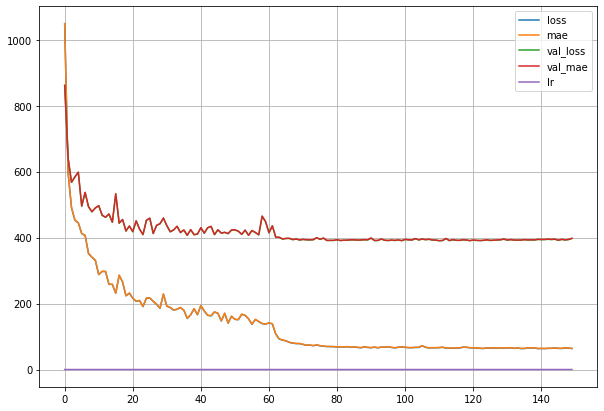

In [78]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.show()

In [79]:
scores = model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 2ms/step - loss: 382.3043 - mae: 382.8028


In [80]:
preds = model.predict(X_test, verbose=1)

33/33 [==============================] - 0s 2ms/step


In [81]:
from scipy import stats

In [82]:
confidence = 0.95

abs_errors = abs(preds.flatten() - y_test.to_numpy().flatten())
stats.t.interval(confidence, len(abs_errors)-1, 
                         loc=abs_errors.mean(), 
                         scale=stats.sem(abs_errors))

(350.60446449129694, 415.00121335409386)

In [83]:
# CI with model 2 & reduce_lr (353.13518581186594, 415.448782334133) ---> (349.8813049279353, 414.6199550540764)

# CI with model 1 & reduce_lr (348.6903547674969, 413.900172246969)

# it appears model complexity only marginally improves preformance

In [84]:
model.save("brooklyn_model.h5")

In [85]:
# /content/drive/MyDrive/Boro_DFs/
model.save("/content/drive/MyDrive/Boro_DFs/brooklyn_model.h5")